In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.colors as mcolors
#adapted from Matlab script by Karthaus Mars group 2022, F. Oraschewski, A. Klose and F. Temme

In [12]:
def simulate_temperature(G,t,T_surf,cycle_G): 
    acc = 0.01  # Surface accumulation
    dz      = 10                    # depth spacing
    H_0     = 1500                  # Current ice cap thickness(m)
    z       = np.arange(0, H_0, dz) # spacing vector
    t_n             = len(t)  # number of time steps
    z_n     = len(z)                # number of spacial steps
    # Spatial settings
    w       = acc*(z/H_0+1)         # approximation of vertical velocity

    T_save      = np.zeros((z_n, t_n))
    Tpmp        = 273.15 + (H_0 - z) * 8.7e-4  # Temperature of pressure melting point

    if cycle_G:
        G_variable  = 0.04
        G_cycle     = G + G_variable * np.sin(t / t_cycle * (1/4) * np.pi)
        G           = G_cycle

    # thermal conductivity settings
    K   = 2.1 * secperyear  # W m ^ -1, thermal conductivity 

    # specific heat settings
    c   = 152.5 + 7.122 * T_save[:,0]

    # density
    rho_ice     = 917
    rho         = rho_ice

    # Thermal diffusivity
    k   = K/(rho * c)  

    # initialization
    if cycle_G:
        T_save[:, 0]    = T_mean + (H_0 - z) * 0  # initialization of temperature
    else: 
        T_save[:, 0]    = T_mean + (H_0 - z) * 0  # initialization of temperature
    f               = z * 0.  # initialization of term 1
    g               = z * 0.  # initialization of term 2

    for kk in range(t_n - 1):
        T_old   = T_save[:,kk]  # initialization of temperature
        T_new   = np.copy(T_old)
        #K[:-1]   = 9.828 * np.exp(-5.7*10**(-3) * T_old[:-1]) * secperyear
        c       = 152.5 + 7.122 * T_save[:,0]
        k       = K/(rho * c)
        
        # iteration in space
        for nn in range(z_n - 1):
            alpha   = (k[nn] / dz + w[nn]) * dt / dz
            beta    = 1 + (2 * k[nn] / dz + w[nn]) * dt / dz
            gamma   = k[nn] * dt / dz ** 2
            if nn == 0:
                f[nn] = 1
                if cycle_G:
                    g[nn] = G[kk] * secperyear * dz / K
                else: 
                    g[nn] = G * secperyear * dz / K
            else:
                f[nn] = alpha / (beta - gamma * f[nn - 1])
                g[nn] = (T_old[nn] + gamma * g[nn - 1]) / (beta - gamma * f[nn - 1])

        T_new[-1] = T_surf[kk]  # upper boundary condition (surface temperature)
        for nn in reversed(range(z_n - 1)):
            T_new[nn]   = T_new[nn + 1] * f[nn] + g[nn]
            if T_new[nn] > Tpmp[nn]:
                T_new[nn]   = Tpmp[nn]

        T_save[:,kk + 1] = T_new
    
    return T_save, t, z
    
    # if t[kk] > settle_cycles * t_cycle and T_new[0]>T_melting:
         
    #     plt.plot(T_new, z, '-')
    #     plt.xlim([145, 300])
    #     plt.plot(T_melting * np.ones(np.shape(T_new)), z, 'k')
    #     plt.xlabel('Temperature (K)')
    #     plt.ylabel('Height (m)')
    #     text=plt.text(250,10,np.str(t[kk]/1000) + ' ka')
    #     text.set_bbox(dict(facecolor='white', alpha=1.0, edgecolor='white'))

    #     plt.pause(0.05)
    # elif t[kk] > settle_cycles * t_cycle and T_new[0]<T_melting:
    #     plt.plot(T_new, z, '--')
    #     plt.xlim([145, 300])
    #     plt.plot(T_melting * np.ones(np.shape(T_new)), z, 'k')
    #     plt.xlabel('Temperature (K)')
    #     plt.ylabel('Height (m)')
    #     plt.pause(0.05)
    

/var/folders/q5/9bzlkvcx1glgh6zpxpsqsmm40000gn/T/ipykernel_78831/1893529384.py:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if aux[0] != []:


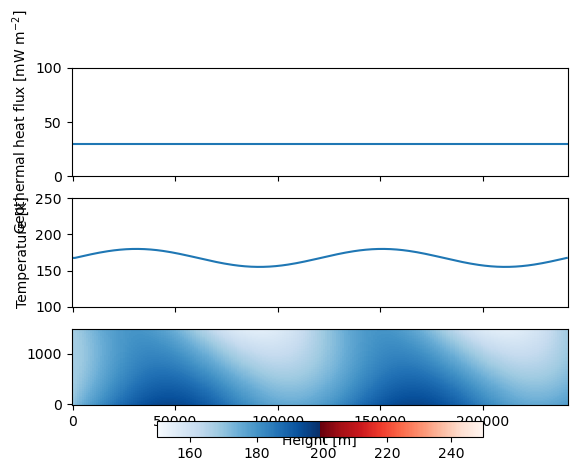

In [13]:
cycle_G     = False 

G   = 0.03  # W m ^ -2, Geothermal heat flux

# Constants
secperyear = 31556926  # seconds per Earth year

# Time settings:
t_cycle         = 120000  # time of glacial cycle
dt              = 1000  # time step
settle_cycles   = 1
timemax         = (settle_cycles + 1) * t_cycle + dt + 1  # modelled time
t               = np.arange(0, timemax, dt)  # time vector


# Temperature settings
T_deltaMean = 10 
T_mean      = 157.5  + T_deltaMean  # Mean temperature over glacial cycle
T_variable  = 12.4  #
T_abs       = 273.15 # Absolute temperature
T_surf      = T_mean + T_variable * np.sin(t / t_cycle * 2 * np.pi)  # surface temperature

T_save, t, z = simulate_temperature(G,t,T_surf,cycle_G)

colors1     = plt.cm.Reds_r(np.linspace(0., 1, 128))
colors2     = plt.cm.Blues(np.linspace(0., 1, 128))
colorsMap   = np.vstack((colors2, colors1))
mymap       = mcolors.LinearSegmentedColormap.from_list('my_colormap', colorsMap)
mymap       = np.flip(mymap)
T_melting   = 199


fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True)
if cycle_G:
    ax1.plot(t,1000*G)
else:
    ax1.plot(t,1000*G*np.ones(np.shape(t)))
ax1.set_ylim([0,100])
ax1.set_ylabel('Geothermal heat flux [mW m$^{-2}$]')

ax2.plot(t,T_save[-1,:])
ax2.set_ylim([100,250])
ax2.set_ylabel('Temperature [k]')

divnorm = colors.TwoSlopeNorm(vmin=150, vcenter=T_melting, vmax=250)
cb = ax3.pcolor(t,z,T_save, norm=divnorm, cmap=mymap)
ax3.set_xlabel('time')
ax3.set_xlabel('Height [m]')
plt.colorbar(cb, ax=ax3, location='bottom')

aux = np.where(T_save[0,:]>T_melting)
if aux[0] != []:
    ax1.axvspan(t[aux[0][1]], t[aux[0][-1]], color='grey', alpha=0.2)
    ax2.axvspan(t[aux[0][1]], t[aux[0][-1]], color='grey', alpha=0.2)

plt.show()


In [64]:
from scipy import signal

corr = signal.correlate(T_save[-1,:]/np.mean(T_save[-1,:]),T_save[0,:]/np.mean(T_save[0,:]),mode='full')
lags = signal.correlation_lags(T_save[-1,:].size, T_save[0,:].size, mode="full")
lag = lags[np.argmax(corr)]

In [65]:
np.argmax(np.correlate(T_save[-1,:]/np.mean(T_save[-1,:]),T_save[0,:]/np.mean(T_save[0,:]),mode='full'))

241

In [63]:
len(np.correlate(T_save[-1,:]/np.mean(T_save[-1,:]),T_save[0,:]/np.mean(T_save[0,:]),mode='full'))

483

In [31]:
t[np.argmax(T_save[0,:])]
t[np.argmax(T_save[-1,:])]

31000

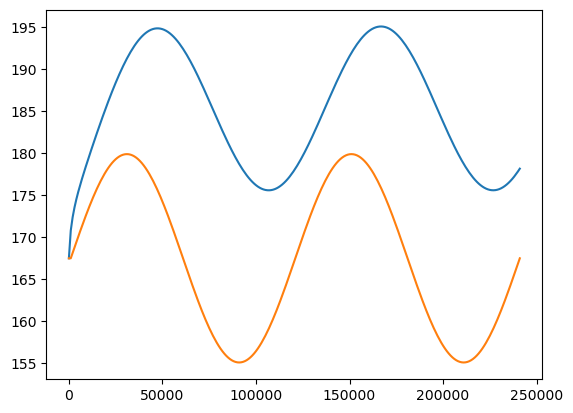

In [28]:
plt.plot(t,T_save[0,:])
plt.plot(t,T_save[-1,:])

In [79]:
t = np.linspace(0,100)
test1 = np.sin(t/(2*np.pi))
test2 = np.sin((t-10)/(2*np.pi))

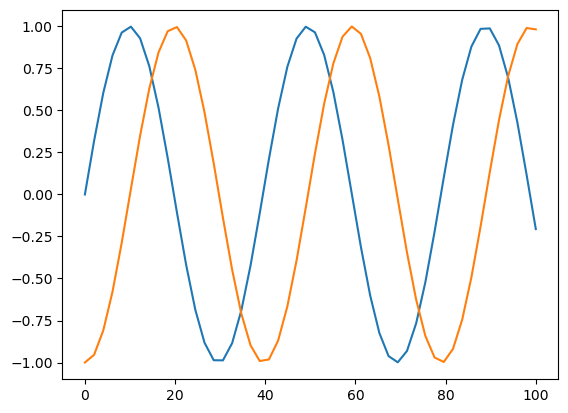

In [80]:
plt.plot(t,test1)
plt.plot(t,test2)


In [83]:
corr = signal.correlate(test1,test2,mode='full')
lags = signal.correlation_lags(test1.size, test2.size, mode="full")
lag = lags[np.argmax(corr)]

In [84]:
lag

-5

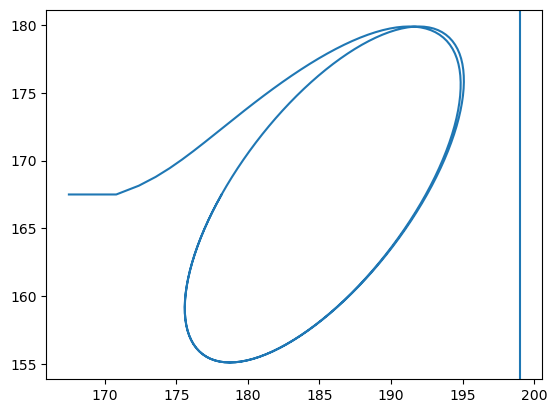

In [4]:
plt.plot(T_save[0,:],T_save[-1,:])
plt.axvline(199)

In [110]:
# Now we can try with varying GHF
GHFs = np.linspace(0.01,0.09,5)
T_vars = np.linspace(0,40,10)
T_means = np.linspace(100,200,10)
t_shift = np.linspace(0,120000,5)
T_b_present = np.zeros((len(t_shift),len(GHFs),len(T_means),len(T_vars)))

cycle_G = False
G = 0.03
for i in range(len(t_shift)):
    for j in range(len(GHFs)):
        for k in range(len(T_means)):
            for l in range(len(T_vars)):
                T_surf      = T_means[k] + T_vars[l] * np.sin((t+t_shift[i]) / t_cycle * 2 * np.pi)  # surface temperature
                T_save, t, z = simulate_temperature(GHFs[j],t,T_surf,cycle_G)
                T_b_present[i,j,k,l] = T_save[0,-1]

Text(0.35, 0.07, 'Outer x: Geothermal heat flux, Inner x: Mean surface temperature [K]')

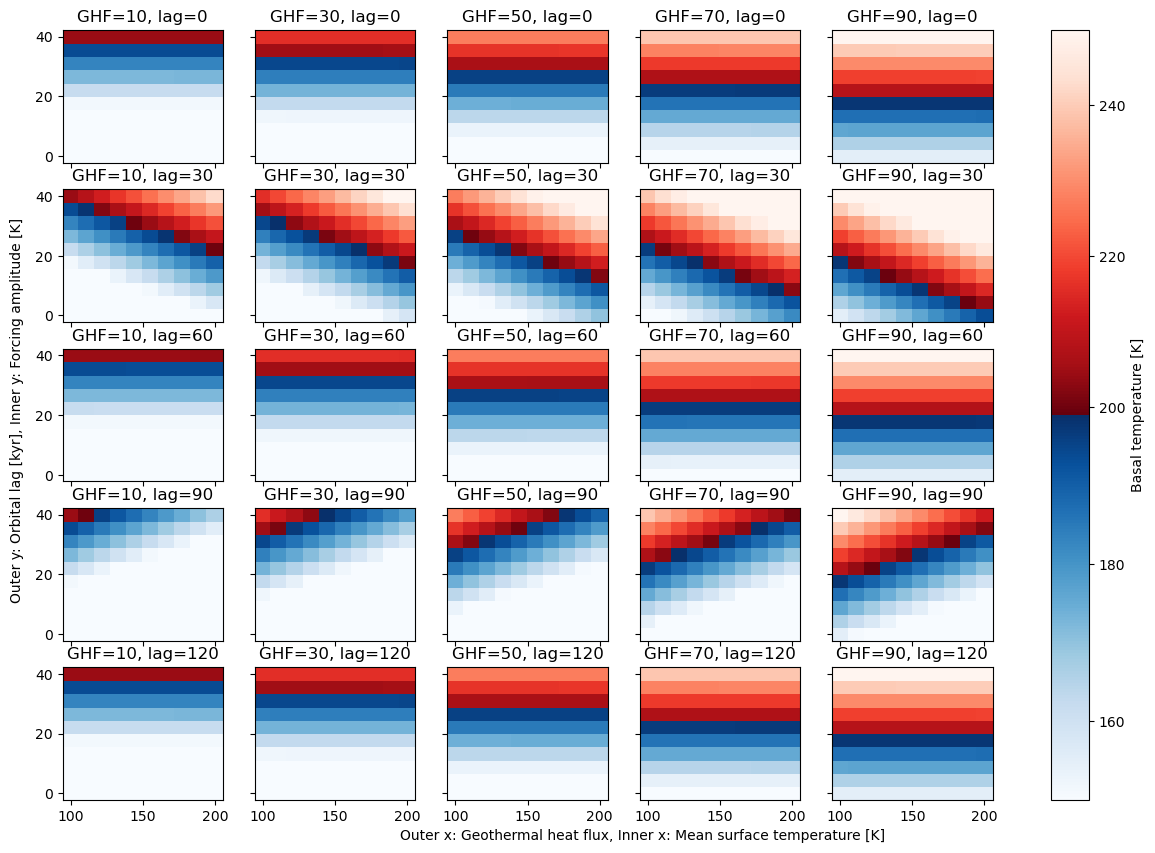

In [111]:
fig = plt.figure(figsize = (15,10))
ax = fig.subplots(len(t_shift),len(GHFs),sharex=True,sharey=True)
for i in range(len(t_shift)):
    for j in range(len(GHFs)):
        cb = ax[i,j].pcolor(T_means,T_vars,T_b_present[i,j,:,:],norm=divnorm,cmap=mymap)
        ax[i,j].set_title(f'GHF={1000*GHFs[j]:.0f}, lag={t_shift[i]/1000:.0f}')

c = plt.colorbar(cb, ax = ax)
fig.text(0.09, 0.5, 'Outer y: Orbital lag [kyr], Inner y: Forcing amplitude [K]', va='center', rotation='vertical')
c.set_label('Basal temperature [K]')
fig.text(0.35, 0.07, 'Outer x: Geothermal heat flux, Inner x: Mean surface temperature [K]')


In [7]:
import scipy.io
mat = scipy.io.loadmat('Mars_temperature_reconstruction.mat')

In [11]:
mat

{'__header__': b'MATLAB 5.0 MAT-file Platform: nt, Created on: Wed May 31 14:58:49 2023',
 '__version__': '1.0',
 '__globals__': [],
 'time_kyr_bp': array([[     0],
        [    -1],
        [    -2],
        ...,
        [-20998],
        [-20999],
        [-21000]], dtype=int16),
 'low': array([[140.42285343, 140.54657885, 140.73132583, ..., 160.25977782,
         160.49241978, 160.78877814]]),
 'high': array([[195.32867879, 195.50078129, 195.75776498, ..., 222.92190981,
         223.24551558, 223.65775109]]),
 'medium': array([[169.1838935 , 169.33296004, 169.55554641, ..., 193.08376466,
         193.36405573, 193.72111343]])}

In [95]:
np.max(mat['low'])-np.min(mat['low'])

47.26360436318154